# Main results plotting file.

This notebook contains the code for reproducing the main results plots in the paper.  This includes Figures 4, 5 \& B.3.  

The code is designed to read in and plot multiple experimental repeats for multiple experiments launched using the scripts in `cluster_scripts`, or, single experimental runs just by running the `RunA2DExperiments.py` files in `./../tests`.  

As with most sets of plotting code, this is a bit crazy in places.  It was also originally rigged to make very specifically formatted figures for the paper.  Therefore, editting any one line of code in here may cause the plot to explode, and look terrible in general.  

There is also something a bit weird in the notebook: I often find I have to run all of the cells, and then run them all again (without restarting the kernel) before the plots come out looking correct.  Thereafter it normally works great.

Feel free to rip up this code and/or nab parts of it for your own purposes.  

In [47]:
# Standard imports.
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import csv
import os
from pathlib import Path
from copy import deepcopy
from matplotlib import rc
from matplotlib.font_manager import FontProperties

# Put Matplotlib into notebook mode and change the font.
# If LaTeX x MatPlotLib is not configured on your machine, then comment this section.
%matplotlib notebook
rc('font',**{'family':'serif',
             'serif':['Palatino'], 
             'size': 8,})
rc('text', usetex=True)

# Change the dimensions of the notebook to fit window,
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Define a bunch of nice colours we will use.
from colormap import hex2rgb
muted_colours_list = ["#4878D0", "#D65F5F", "#EE854A", "#6ACC64", "#956CB4",
                      "#8C613C", "#DC7EC0", "#505050", "#D5BB67", "#82C6E2"]
muted_colours_list = np.asarray([hex2rgb(_c) for _c in muted_colours_list]) / 256
muted_colours_dict = {'blue':   muted_colours_list[0],
                      'red':    muted_colours_list[1],
                      'orange': muted_colours_list[2],
                      'green':  muted_colours_list[3],
                      'purple': muted_colours_list[4],
                      'brown':  muted_colours_list[5],
                      'pink':   muted_colours_list[6],
                      'gray':   muted_colours_list[7],
                      'yellow': muted_colours_list[8],
                      'eggsh':  muted_colours_list[9]}

# These are the textual keys for the different experiments.
exp_keys = ['RL_state', 
            'RL_partial_state', 
            'RL_observe', 
            'D_state', 
            'AD_partial_state',
            'AD_full_observe', 
            'AD_observe', 
            'A2D_partial_state',
            'A2D_observe',
            'A2D_state',
            'ete_observe',
            'RL_observe_asym']

# # These are the columns in the results.csv file.
# Algorithm steps - 0.
# Interactions -    1.
# MDP eval -        2.
# POMDP eval -      3.
# Mixed eval -      4.
# beta -            5.
# projection loss - 6.
# MDP stoch -       7.
# POMDP stoch -     8.
# Mixed stoch -     9.

# Some other colour / visual settings.
fill_alpha = 0.4
main_line_width = 1.5
edge_alpha = 0.8

# Some plotting options.
STOCHASTIC_POLICY = True
INTERACTIONS = True
SCALE = 100000
APPLY_PRETRAIN_TO = ['AD', 'ete']
X_LOG_SCALE = False
Y_LOG_SCALE = True

# Set this to true and it will take only experimental repeats that are full-length.
# Otherwise, it will crop all experimental repeats to the shortest length.
PLOT_ONLY_COMPLETE = True

# Assign colours that we will use for each channel.
cols_dict = {'RL_state':           np.asarray([0.8, 0.8, 0.8, 1.0]),
             'RL_partial_state':   muted_colours_dict['orange'],
             'RL_observe':         muted_colours_dict['red'], 
             'AD_partial_state':   muted_colours_dict['yellow'], 
             'AD_observe':         muted_colours_dict['blue'], 
             'A2D_partial_state':  muted_colours_dict['brown'], 
             'A2D_observe':        muted_colours_dict['green'], 
             'ete_observe':        muted_colours_dict['eggsh'],
             'D_state':            muted_colours_dict['eggsh'], 
             'A2D_state':          muted_colours_dict['eggsh'], 
             'AD_full_observe':    muted_colours_dict['eggsh'], 
             'ARL_observe':        muted_colours_dict['yellow'], }

# Paper and figure size.
paper_width = 5.5  # INCHES.
fig_size = (paper_width * 1.25 / 2.0, 
            paper_width * 1.25 / 4.0)

# Define the text labels what will appear in the legend for each channel.
labels = {'RL_state':                 'RL (MDP)', 
          'RL_partial_state':         'RL (Compact)',
          'RL_observe':               'RL',
          'D_state':                  'DAgger',
          'AD_partial_state':         'AIL',
          'AD_full_observe':          'AIL',
          'AD_observe':               'AIL',
          'A2D_partial_state':        'A2D (Compact)', 
          'A2D_observe':              'A2D (Image)',
          'A2D_state':                'A2D',
          'ete_observe':              'Pre-Enc',
          'ARL_observe':              'RL (Asym)', }


# If plotting results for rolling out under deterministic policy we need to select
# a different column.
if STOCHASTIC_POLICY:
    shift = 0  # 0 for stochastic.
else:
    shift = 5  # 5 for deterministic.
    

# Select which column to use. 
column_to_pick = {  'RL_state':           7 - shift, # NOTE - the RL code always uses the MDP slot...
                    'RL_partial_state':   8 - shift,
                    'RL_observe':         8 - shift,
                    'D_state':            8 - shift, 
                    'AD_partial_state':   8 - shift, 
                    'AD_full_observe':    8 - shift, 
                    'AD_observe':         8 - shift, 
                    'A2D_partial_state':  8 - shift, 
                    'A2D_observe':        8 - shift, 
                    'A2D_state':          8 - shift, 
                    'ete_observe':        8 - shift, 
                    'ARL_observe':        8 - shift}  # TODO - this should probably be 8 - minus.


# Default args to savefig.
save_options = {'bbox_inches': 'tight', 
                'pad_inches': 0.05}

In [48]:
leg = None
shift = 0


# Put the main plotting code in a little standalone function.
# Generates Figure 4 \& B.3.
def do_reward_plot():
    
    # Make a new figure.
    fig = plt.figure()
    ax = plt.gca()
    
    # fig_size_ = (fig_size[0] * 0.85, fig_size[1])
    fig_size_ = (fig_size[0], fig_size[1])
    fig.set_size_inches(fig_size_)
    
    plt.tight_layout()
    
    global leg, shift

    print("Plotting: ", reward_per_iter.keys())
    
    for _k in reward_per_iter.keys():
        _data = reward_per_iter[_k]
        
        # Are we plotting interactions for episodes?
        # Pretrain shifting is not implemented for episodes.
        if INTERACTIONS:
            # Work out if we are applying some pre-training shift.
            _shift = 0
            for _l in APPLY_PRETRAIN_TO:
                if _l in _k:
                    # We need to get pretrain shift out so assign
                    # to a separate global variable.
                    shift = PRETRAIN_SHIFT
                    _shift = PRETRAIN_SHIFT
            _x = interactions[_k] + _shift
            
            xlabel = r'Environment Interactions ($\times 10^{5}$)'
        else:
            xlabel = 'Episodes'
            
        print(_k, np.shape(_data))
        
        # Sort out data.
        _uqu = np.quantile(_data, 0.25, axis=0)
        _lqu = np.quantile(_data, 0.75, axis=0)
        _med = np.median(_data, axis=0)

        # Plot median line.
        ax.plot(_x / SCALE, _med, color=cols_dict[_k], label=labels[_k], linewidth=main_line_width)
        
        # Make quartiles fill.
        ax.fill_between(_x / SCALE, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)
        ax.plot(_x / SCALE, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        ax.plot(_x / SCALE, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        
        
    # Add the asymptotic performance lines.
    keys = list(asymptotic_performance.keys())
    ls = ['--', ':', '.']
    for _k in range(len(asymptotic_performance.keys())):
        _y = asymptotic_performance[keys[_k]]
        plt.plot([0, max(_x / SCALE)], [_y, _y], linestyle=ls[_k], c='k', label=keys[_k], 
                 linewidth=0.5, zorder=0)  # np.inf)
        
        
    # Add the pretrain shift line if we used pretraining.
    if (PRETRAIN_SHIFT != 0) and (shift != 0):
        lim = plt.ylim()
        plt.plot((PRETRAIN_SHIFT / SCALE, PRETRAIN_SHIFT / SCALE), (lim[0], lim[1]), 
                 zorder=-np.inf, linestyle='--', c=cols_dict['RL_state'])
        plt.ylim(lim)

#     # Place legend off to one side. 
#     fontP = FontProperties()
#     fontP.set_size('small')
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#     leg = ax.legend(loc='right', bbox_to_anchor=(box.width * 2.0, 0.4),
#               ncol=5, fancybox=True, facecolor=[0.97, 0.97, 0.97], 
#               edgecolor='k', prop=fontP, framealpha=1.0)

    # Some final figure stuff.
    ax.margins(0.02, 0.2, tight=None)
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Reward')
    
    if X_LOG_SCALE:
        plt.xscale('log')

    # The y-scale can be positive or negative, so use symlog.
    if Y_LOG_SCALE:
        plt.yscale('symlog')

    # Let the limits.
    plt.xlim(0, np.round(max_interactions / SCALE))
    plt.ylim(-240, -0.5)
    
    save_name = '{}_results_{}_{}_{}.pdf'.format(tag, EXP_LABEL, STOCHASTIC_POLICY, exp_main.replace('/', '_'))
    print('Main save target is: ', save_name)
        
    plt.savefig(str(Path.home()) + '/Downloads/' + save_name, **save_options)
    # plt.savefig(str(Path.home()) + '/Downloads/' + 'legend_' + save_name, **save_options)
    plt.savefig(exp_root + save_name, **save_options)
    
    # Return the legend object.
    return leg

    


In [49]:


# Generate the divergence plot.
# Generates Figure 5.
def do_divergence_plot():
    
    fig = plt.figure()
    ax = plt.gca()
    fig.set_size_inches(fig_size)
    fig.tight_layout()
    
    divergence_keys_to_plot = ['AD_observe', 'A2D_partial_state', 'A2D_observe']
    
    for _k in divergence_keys_to_plot:
    
        # If the divergences are all zero we probably didn't 
        # compute them.
        if np.all(divergences[_k] == 0.0):
            print('Skipping (zeros): ', _k)
            continue

        # Sometimes Pre-enc/E.T.E has a divergence in it, but we
        # don't want to plot that here.
        if _k == 'ete_observe':
            print('Skipping (E.T.E):   E.T.E.')
            continue

        try:
            # TODO - IN HERE DECIDE IF EPISODE OR INTERACTION.
            INTERACTIONS = True
            if INTERACTIONS:
                _x = deepcopy(interactions[_k])
                xlabel = r'Environment Interactions ($\times 10^{5}$)'
            else:
                _x = deepcopy(iters[_k])
                xlabel = 'Episodes'

            plt.xlabel(xlabel)

            _div = divergences[_k].T
            _med = np.median(_div, axis=1)
            _lqu = np.quantile(_div, 0.25, axis=1)
            _uqu = np.quantile(_div, 0.75, axis=1)
            
            plt.plot(_x / SCALE, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha, zorder=-np.inf)
            plt.plot(_x / SCALE, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha, zorder=-np.inf)
            plt.plot(_x / SCALE, _med, color=cols_dict[_k], label=labels[_k], linewidth = main_line_width, zorder=np.inf)
            plt.fill_between(_x / SCALE, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)

        except Exception as err:
            print(err)
            
        plt.ylabel(r'$\mathbb{KL}$ Div., $F(\psi)$')
        plt.grid(True)
        
        Y_LOG = True
        if Y_LOG:
            plt.yscale('log')
        else:
            plt.ylim(0.0, 5.0)
            pass

#         # Place legend.|
#         fontP = FontProperties()
#         fontP.set_size('small')
#         ax.legend(loc='lower center',
#                   ncol=3, fancybox=True, facecolor=[0.97, 0.97, 0.97], 
#                   edgecolor='k', prop=fontP, framealpha=1.0,
#                   handlelength=1.0,handletextpad=0.5, columnspacing=0.5)


        plt.ylim(0.000001, 1.0)
        plt.xlim(0, np.round(max_interactions / SCALE))
        plt.yticks([0.000001, 0.001, 1.0])


        save_name = '{}_divergence_{}_{}_{}.pdf'.format(tag, EXP_LABEL, STOCHASTIC_POLICY, exp_main.replace('/', '_'))
        plt.savefig(str(Path.home()) + '/Downloads/' + save_name, **save_options)
        plt.savefig(exp_root + save_name, **save_options)

        




Ignoring Files:  []


Loaded 20 RL_state experiments.
Loaded 20 RL_observe experiments.
Loaded 20 ARL_observe experiments.
Loaded 20 AD_observe experiments.
Loaded 20 ete_observe experiments.
Loaded 20 A2D_partial_state experiments.
Loaded 20 A2D_observe experiments.
Complete Keys: ['RL_state', 'RL_observe', 'ARL_observe', 'AD_observe', 'ete_observe', 'A2D_partial_state', 'A2D_observe']


<IPython.core.display.Javascript object>


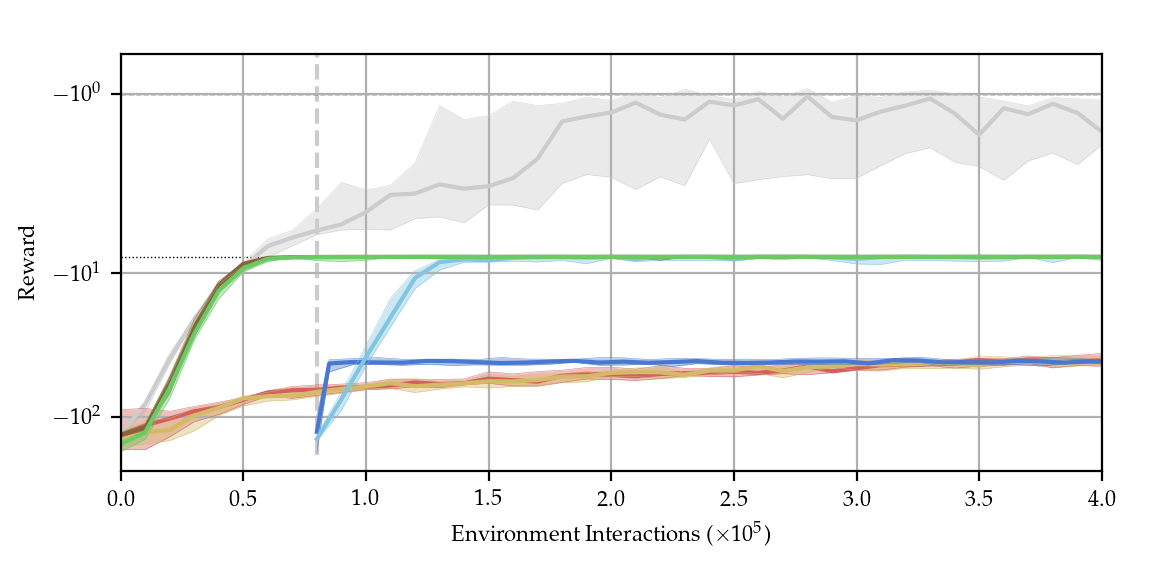

Plotting:  dict_keys(['RL_state', 'RL_observe', 'ARL_observe', 'AD_observe', 'ete_observe', 'A2D_partial_state', 'A2D_observe'])
RL_state (20, 41)
RL_observe (20, 41)
ARL_observe (20, 41)
AD_observe (20, 42)
ete_observe (20, 41)
A2D_partial_state (20, 41)
A2D_observe (20, 41)
Main save target is:  sec4_results_IceLake_True_cr_logs_LavaGap_LavaGapCompiledRun_.pdf


<IPython.core.display.Javascript object>


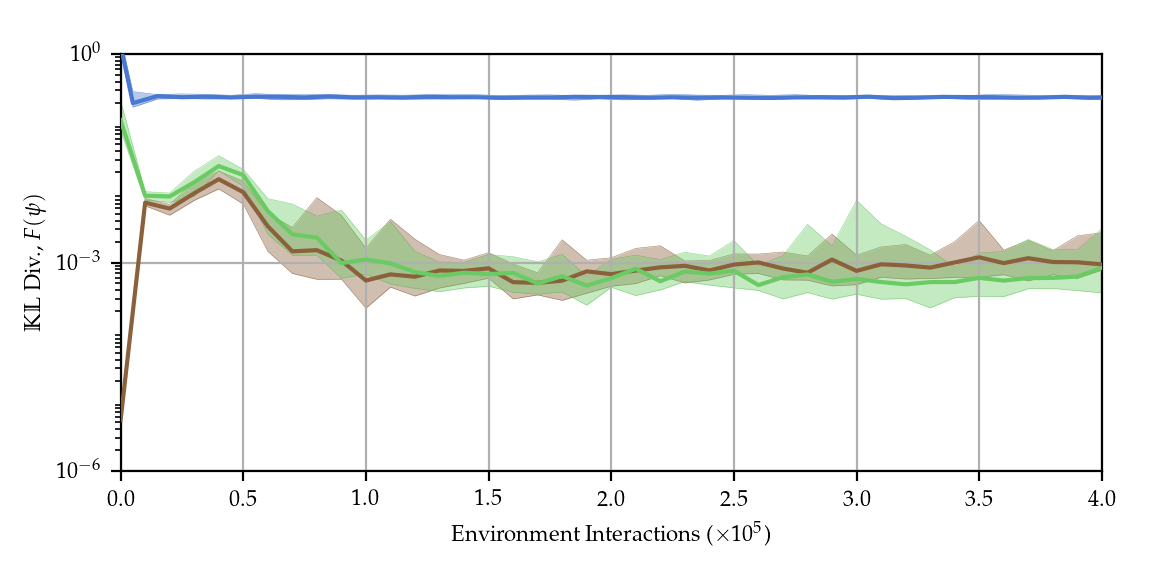

In [51]:
# Where is the main results folder?
exp_root = './../tests/results/AdaptAsymDagger/'

# Pick the individual experiment to plot.
# exp_main = 'cr_logs/TigerDoor/TigerDoorCompiledRun/'
exp_main = 'cr_logs/LavaGap/LavaGapCompiledRun/'


# -------------------------------------------------------------------------
# Set which channels we want to plot.
# # # USE ALL EXPERIMENTS.
# experiments = [directories[_k] for _k in list(directories.keys())]
# tag = 'all'

# SECTION 4 EXPERIMENTS.
experiments = ['RL_state', 'RL_observe', 'ARL_observe', 'AD_observe', 'ete_observe', 'A2D_partial_state', 'A2D_observe']
tag = 'sec4'

# # # A2D plot,
# experiments = ['RL_partial_state', 'RL_observe', 'A2D_partial_state', 'A2D_observe']
# tag = 'a2d'

# # Random.
# experiments = ['A2D_observe']
# tag = 'random'
# -------------------------------------------------------------------------



# Define asymptotic performances and other parameters of each environment.
if 'Lava' in exp_main:
    asymptotic_performance = {'MDP': 10.66,
                              'POMDP': 4.0}
    reward_sub = 11.66
    reward_mul = 1.0
    EXP_LABEL = 'IceLake'
    PRETRAIN_SHIFT = 80000
    
elif 'Tiger' in exp_main:
    asymptotic_performance = {'MDP': 6.0,
                              'POMDP': 2.0}
    reward_sub = 7.0
    reward_mul = 1.0
    EXP_LABEL = 'TigerDoor'
    PRETRAIN_SHIFT = 80000

else:
    raise NotImplementedError("Environment not recognised!")
        

# If there are individual repeats that you want to exclude, specify them here.
FILES_TO_IGNORE = []
print('\n')
print("Ignoring Files: ", FILES_TO_IGNORE)
print('\n')

# Make location to load.
exp_root += exp_main

# Scan the reports to get the indexes on the experiments that we can plot.
files = os.listdir(exp_root)
seeds = []
for _r in files:
    if 'report' in _r:
        _seed = _r.replace('report_', '').replace('.txt', '')
        if _seed not in FILES_TO_IGNORE:
            seeds.append(_seed)

# Modify the asymtotic performance if we are shifting.
for _k in asymptotic_performance.keys():
    asymptotic_performance[_k] -= reward_sub
    asymptotic_performance[_k] *= reward_mul

# Process the results files.
results = {}
data = {}

# Loop over each channel/experiment we are plotting.
for _e in experiments:
    
    try:
        _f = exp_root + _e
        data_raw = []
        lengths = []

        # Iterate over each individual experiment loading the results csv.
        for _s in seeds:
            try:
                file = '{}/{}/results.csv'.format(_f, _s)

                with open(file, newline='') as csvfile:
                    spamreader = csv.reader(csvfile, delimiter=',')
                    next(spamreader, None)  # Skip the header.
                    _data_raw = []
                    for row in spamreader:
                        _data_raw.append(row)

                data_raw.append(_data_raw)
                lengths.append(len(_data_raw))
            except Exception as err:
                print(err)
                pass
            
        # Are we plotting all data, or full traces only?
        if PLOT_ONLY_COMPLETE:
            data_raw = [_d for _d in data_raw if (len(_d) == np.max(lengths))]
        else:
            data_raw = [_d[:np.min(lengths)] for _d in data_raw]

        # Format the data traces.
        data_raw = np.asarray(data_raw).astype(np.float)
        data[_e] = data_raw
        
        print('Loaded {} {} experiments.'.format(len(data_raw), _e))

    except Exception as err:
        print('Loading {} failed: '.format(_e), err)
        
    
# Format the data traces into the four dictionaries:
# reward_per_iter - reward to plot for each method.
# divergences - divergence for each method (lots of these will be empty).
# iters - the number of iterations at each point.
# interactions - the number of environment interactions at each point.
results = {}
reward_per_iter = {}
iters = {}
interactions = {}
divergences = {}
EXPERT_REWARD = {}
print("Complete Keys:", list(data.keys()))

for _k in data.keys():
    
    try:
        # Check it can load all entries.
        data[_k][:, :, column_to_pick[_k]] 
        data[_k][:, :, 0]
        data[_k][:, :, 1]
        data[_k][:, :, 6]

        # Define the formatted dictionaries that hold the results.
        reward_per_iter[_k] = (data[_k][:, :, column_to_pick[_k]] - reward_sub) * reward_mul
        divergences[_k] = data[_k][:, :, 6]
        iters[_k] = np.mean(data[_k][:, :, 0], axis=0)
        interactions[_k] = np.mean(data[_k][:, :, 1], axis=0)

        # Search for divergences that are not filled in (=90210)
        divergences[_k][divergences[_k] == 90210.0] = np.nan
        
    except Exception as err:
        print(_k, 'failed')
        print(err)
        pass
    

# Work out the x-limit to use.
try:
    max_interactions = np.max([np.max(interactions[_k]) for _k in interactions.keys()])
except:
    max_interactions = 0

    
# Call the two plotting functions.
do_reward_plot()
do_divergence_plot()